# Image processing pipeline

Normalization → Otsu thresholding → Multi-Otsu segmentation → Morphological operations

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from PIL import Image
import os
from pathlib import Path
from scipy import ndimage

from skimage.filters import threshold_otsu
from skimage import data, filters, color, morphology, segmentation, measure, io
from skimage.filters import threshold_multiotsu
from skimage.morphology import flood_fill
from skimage.color import label2rgb

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

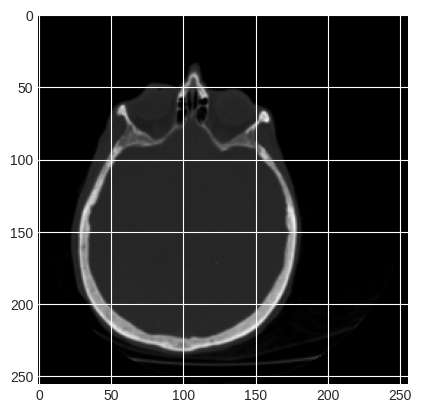

In [3]:
br = data.brain()
img = br[4]

# Normalize image to 8-bit (0-255)
img_normalized = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
plt.imshow(img_normalized, cmap='gray')

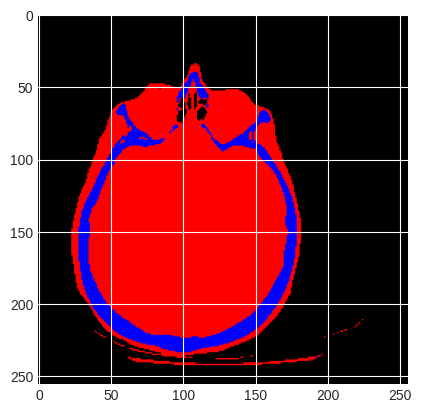

In [21]:
threshold = [20, 70]
regions = np.digitize(img_normalized, bins=threshold)
regions_colorised = label2rgb(regions)
plt.imshow(regions_colorised)

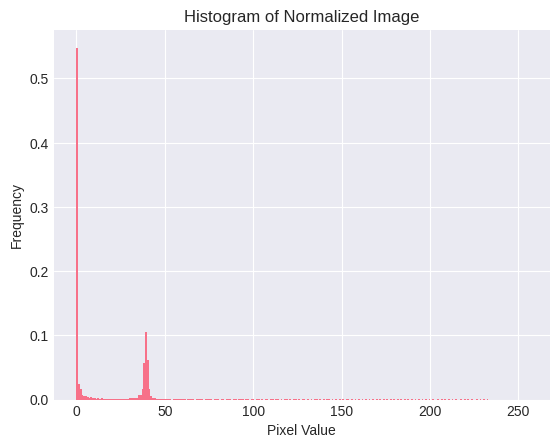

In [19]:
plt.hist(img_normalized.ravel(), bins=256, range=(0, 255), density=True)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Normalized Image')
plt.show()

# THRESHOLDING

In [4]:
# Multi-Otsu thresholding (3 classes)
thresholds = threshold_multiotsu(img_normalized, classes=3)
print(f"Multi-Otsu thresholds: {thresholds}")
regions = np.digitize(img_normalized, bins=thresholds)

Multi-Otsu thresholds: [ 21 100]


Binary Otsu threshold: 82.00


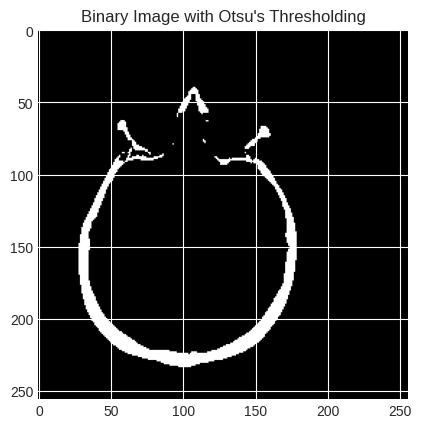

In [5]:
# Standard Otsu thresholding
thresh = threshold_otsu(img_normalized)
binary_otsu = img_normalized > thresh
print(f"Binary Otsu threshold: {thresh:.2f}")

plt.imshow(binary_otsu, cmap='gray')
plt.title("Binary Image with Otsu's Thresholding")
plt.show()

# MORPHOLOGICAL OPERATIONS

Applied opening with disk radius: 1


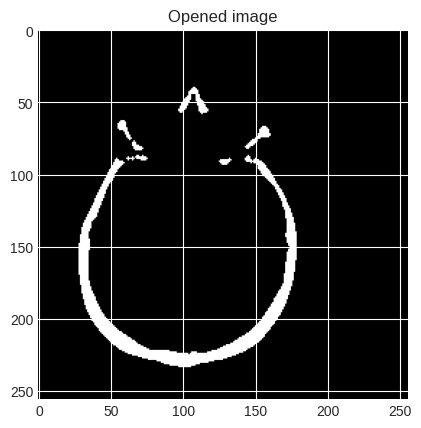

In [6]:
# Applying morphological operations
# Openning: removes small noise
selem_open = morphology.disk(1)
opened_image = morphology.binary_opening(binary_otsu, selem_open)
print(f"Applied opening with disk radius: {selem_open.shape[0]//2}")

plt.imshow(opened_image, cmap='gray')
plt.title("Opened image")
plt.show()

Applied closing with disk radius: 27


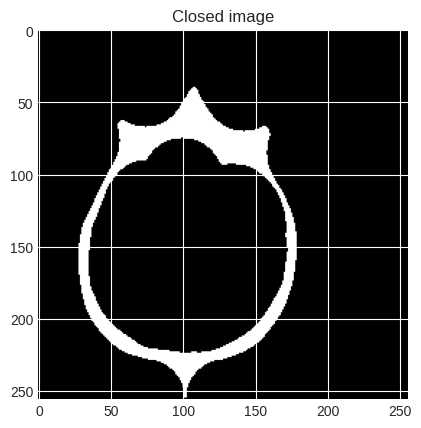

In [7]:
# Closing: fills small holes/gaps
selem_close = morphology.disk(27)
closed_image = morphology.binary_closing(opened_image, selem_close)
print(f"Applied closing with disk radius: {selem_close.shape[0]//2}")

plt.imshow(closed_image, cmap='gray')
plt.title("Closed image")
plt.show()

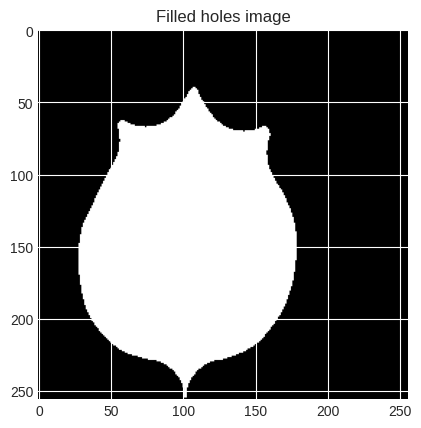

In [15]:
# Remove small holes
filled_holes_image = flood_fill(closed_image, (127, 127), 255, connectivity=4)

# filled_holes_image = morphology.remove_small_holes(closed_image, area_threshold=2500)
# print(f"Removed holes smaller than: 500 pixels")

plt.imshow(filled_holes_image, cmap='gray')
plt.title("Filled holes image")
plt.show()

Difference image area: 15804 pixels


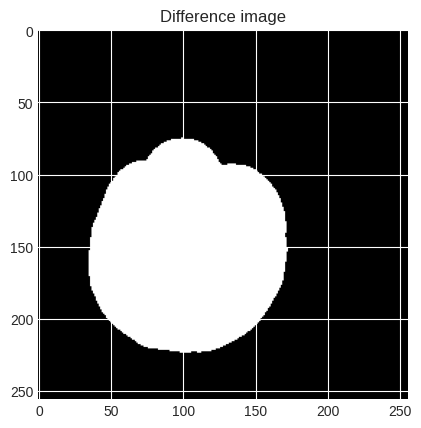

In [17]:
# Extract difference between processed and original binary image
difference_image = filled_holes_image ^ closed_image
print(f"Difference image area: {np.sum(difference_image)} pixels")

plt.imshow(difference_image, cmap='gray')
plt.title("Difference image")
plt.show()

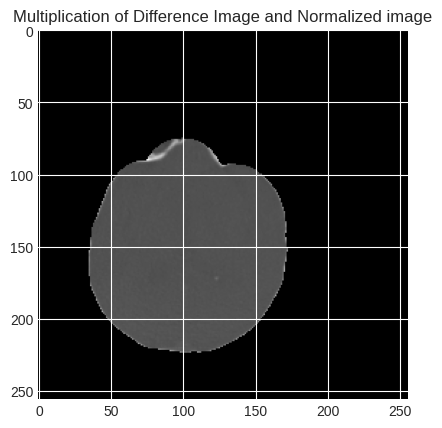

In [18]:
# Apply mask to original image
result_image = difference_image * img_normalized

plt.imshow(result_image, cmap='gray')
plt.title("Multiplication of Difference Image and Normalized image")
plt.show()